# Homework and bake-off: Sentiment analysis

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2021"

## Contents

1. [Overview](#Overview)
1. [Methodological note](#Methodological-note)
1. [Set-up](#Set-up)
1. [Train set](#Train-set)
1. [Dev sets](#Dev-sets)
1. [A softmax baseline](#A-softmax-baseline)
1. [RNNClassifier wrapper](#RNNClassifier-wrapper)
1. [Error analysis](#Error-analysis)
1. [Homework questions](#Homework-questions)
  1. [Token-level differences [1 point]](#Token-level-differences-[1-point])
  1. [Training on some of the bakeoff data [1 point]](#Training-on-some-of-the-bakeoff-data-[1-point])
  1. [A more powerful vector-averaging baseline [2 points]](#A-more-powerful-vector-averaging-baseline-[2-points])
  1. [BERT encoding [2 points]](#BERT-encoding-[2-points])
  1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bakeoff [1 point]](#Bakeoff-[1-point])
1. [Submission Instruction](#Submission-Instruction)

## Overview

This homework and associated bakeoff are devoted to supervised sentiment analysis using the ternary (positive/negative/neutral) version of the Stanford Sentiment Treebank (SST-3) as well as a new dev/test dataset drawn from restaurant reviews. Our goal in introducing the new dataset is to push you to create a system that performs well in both the movie and restaurant domains.

The homework questions ask you to implement some baseline system, and the bakeoff challenge is to define a system that does well at both the SST-3 test set and the new restaurant test set. Both are ternary tasks, and our central bakeoff score is the mean of the macro-FI scores for the two datasets. This assigns equal weight to all classes and datasets regardless of size.

The SST-3 test set will be used for the bakeoff evaluation. This dataset is already publicly distributed, so we are counting on people not to cheat by developing their models on the test set. You must do all your development without using the test set at all, and then evaluate exactly once on the test set and turn in the results, with no further system tuning or additional runs. __Much of the scientific integrity of our field depends on people adhering to this honor code__. 

One of our goals for this homework and bakeoff is to encourage you to engage in __the basic development cycle for supervised models__, in which you

1. Design a new system. We recommend starting with something simple.
1. Use `sst.experiment` to evaluate your system, using random train/test splits initially.
1. If you have time, compare your system with others using `sst.compare_models` or `utils.mcnemar`. (For discussion, see [this notebook section](sst_02_hand_built_features.ipynb#Statistical-comparison-of-classifier-models).)
1. Return to step 1, or stop the cycle and conduct a more rigorous evaluation with hyperparameter tuning and assessment on the `dev` set.

[Error analysis](#Error-analysis) is one of the most important methods for steadily improving a system, as it facilitates a kind of human-powered hill-climbing on your ultimate objective. Often, it takes a careful human analyst just a few examples to spot a major pattern that can lead to a beneficial change to the feature representations.

## Methodological note

You don't have to use the experimental framework defined below (based on `sst`). The only constraint we need to place on your system is that it must have a `predict_one` method that can map directly from an example text to a prediction, and it must be able to make predictions without having any information beyond the text. (For example, it can't depend on knowing which task the text comes from.) See [the bakeoff section below](#Bakeoff-[1-point]) for examples of functions that conform to this specification.

## Set-up

See [the first notebook in this unit](sst_01_overview.ipynb#Set-up) for set-up instructions.

In [1]:
from collections import Counter
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
import torch.nn as nn

from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import sst
import utils

In [2]:
SST_HOME = os.path.join('data', 'sentiment')

## Train set

Our primary train set is the SST-3 train set:

In [5]:
sst_train = sst.train_reader(SST_HOME)

In [6]:
sst_train.shape[0]

8544

This is the train set we will use for all the regular homework questions. You are welcome to bring in new datasets for your original system. You are also free to add `include_subtrees=True`. This is very likely to lead to better systems, but it substantially increases the overall size of the dataset (from 8,544 examples to 159,274), which will in turn substantially increase the time it takes to run experiments.

See [this notebook](sst_01_overview.ipynb) for additional details of this dataset.

## Dev sets

We have two development set. SST3-dev consists of sentences from movie reviews, just like SST-3 train:

In [7]:
sst_dev = sst.dev_reader(SST_HOME)

Our new bakeoff dev set consists of sentences from restaurant reviews:

In [6]:
bakeoff_dev = sst.bakeoff_dev_reader(SST_HOME)

In [7]:
bakeoff_dev.sample(3, random_state=1).to_dict(orient='records')

[{'example_id': 57,
  'sentence': 'I would recommend that you make reservations in advance.',
  'label': 'neutral',
  'is_subtree': 0},
 {'example_id': 590,
  'sentence': 'We were welcomed warmly.',
  'label': 'positive',
  'is_subtree': 0},
 {'example_id': 1968,
  'sentence': 'We have been to Oceanaire twice in the last 6 weeks.',
  'label': 'neutral',
  'is_subtree': 0}]

Here is the label distribution:

In [8]:
bakeoff_dev.label.value_counts()

neutral     1019
positive     777
negative     565
Name: label, dtype: int64

The label distribution for the corresponding test set is similar to this.

## A softmax baseline

This example is here mainly as a reminder of how to use our experimental framework with linear models:

In [9]:
def unigrams_phi(text):
    return Counter(text.split())

Thin wrapper around `LogisticRegression` for the sake of `sst.experiment`:

In [10]:
def fit_softmax_classifier(X, y):
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='ovr')
    mod.fit(X, y)
    return mod

The experimental run with some notes:

In [11]:
softmax_experiment = sst.experiment(
    sst.train_reader(SST_HOME),   # Train on any data you like except SST-3 test!
    unigrams_phi,                 # Free to write your own!
    fit_softmax_classifier,       # Free to write your own!
    assess_dataframes=[sst_dev, bakeoff_dev]) # Free to change this during development!

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.628     0.689     0.657       428
     neutral      0.343     0.153     0.211       229
    positive      0.629     0.750     0.684       444

    accuracy                          0.602      1101
   macro avg      0.533     0.531     0.518      1101
weighted avg      0.569     0.602     0.575      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.272     0.690     0.390       565
     neutral      0.429     0.113     0.179      1019
    positive      0.409     0.346     0.375       777

    accuracy                          0.328      2361
   macro avg      0.370     0.383     0.315      2361
weighted avg      0.385     0.328     0.294      2361

Mean of macro-F1 scores: 0.416


`softmax_experiment` contains a lot of information that you can use for error analysis; see [this section below](#Error-analysis) for starter code.

## RNNClassifier wrapper

This section illustrates how to use `sst.experiment` with `TorchRNNClassifier`.

To featurize examples for an RNN, we can just get the words in order, letting the model take care of mapping them into an embedding space.

In [12]:
def rnn_phi(text):
    return text.split()

The model wrapper gets the vocabulary using `sst.get_vocab`. If you want to use pretrained word representations in here, then you can have `fit_rnn_classifier` build that space too; see [this notebook section for details](sst_03_neural_networks.ipynb#Pretrained-embeddings). See also [torch_model_base.py](torch_model_base.py) for details on the many optimization parameters that `TorchRNNClassifier` accepts.

In [13]:
def fit_rnn_classifier(X, y):
    sst_glove_vocab = utils.get_vocab(X, mincount=2)
    mod = TorchRNNClassifier(
        sst_glove_vocab,
        early_stopping=True)
    mod.fit(X, y)
    return mod

In [14]:
rnn_experiment = sst.experiment(
    sst.train_reader(SST_HOME),
    rnn_phi,
    fit_rnn_classifier,
    vectorize=False,  # For deep learning, use `vectorize=False`.
    assess_dataframes=[sst_dev, bakeoff_dev])

Stopping after epoch 51. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.6513074859976768

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.587     0.577     0.582       428
     neutral      0.233     0.231     0.232       229
    positive      0.642     0.655     0.649       444

    accuracy                          0.537      1101
   macro avg      0.488     0.488     0.488      1101
weighted avg      0.536     0.537     0.536      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.263     0.589     0.364       565
     neutral      0.462     0.239     0.315      1019
    positive      0.450     0.329     0.380       777

    accuracy                          0.353      2361
   macro avg      0.392     0.386     0.353      2361
weighted avg      0.411     0.353     0.348      2361

Mean of macro-F1 scores: 0.421


## Error analysis

This section begins to build an error-analysis framework using the dicts returned by `sst.experiment`. These have the following structure:

```
'model': trained model
'phi': the feature function used
'train_dataset':
   'X': feature matrix
   'y': list of labels
   'vectorizer': DictVectorizer,
   'raw_examples': list of raw inputs, before featurizing   
'assess_datasets': list of datasets, each with the same structure as the value of 'train_dataset'
'predictions': list of lists of predictions on the assessment datasets
'metric': `score_func.__name__`, where `score_func` is an `sst.experiment` argument
'score': the `score_func` score on the each of the assessment dataasets
```
The following function just finds mistakes, and returns a `pd.DataFrame` for easy subsequent processing:

In [15]:
def find_errors(experiment):
    """Find mistaken predictions.

    Parameters
    ----------
    experiment : dict
        As returned by `sst.experiment`.

    Returns
    -------
    pd.DataFrame

    """
    dfs = []
    for i, dataset in enumerate(experiment['assess_datasets']):
        df = pd.DataFrame({
            'raw_examples': dataset['raw_examples'],
            'predicted': experiment['predictions'][i],
            'gold': dataset['y']})
        df['correct'] = df['predicted'] == df['gold']
        df['dataset'] = i
        dfs.append(df)
    return pd.concat(dfs)

In [16]:
softmax_analysis = find_errors(softmax_experiment)

In [17]:
rnn_analysis = find_errors(rnn_experiment)

Here we merge the sotmax and RNN experiments into a single DataFrame:

In [18]:
analysis = softmax_analysis.merge(
    rnn_analysis, left_on='raw_examples', right_on='raw_examples')

analysis = analysis.drop('gold_y', axis=1).rename(columns={'gold_x': 'gold'})

The following code collects a specific subset of examples; small modifications to its structure will give you different interesting subsets:

In [19]:
# Examples where the softmax model is correct, the RNN is not,
# and the gold label is 'positive'

error_group = analysis[
    (analysis['predicted_x'] == analysis['gold'])
    &
    (analysis['predicted_y'] != analysis['gold'])
    &
    (analysis['gold'] == 'positive')
]

In [20]:
error_group.shape[0]

192

In [21]:
for ex in error_group['raw_examples'].sample(5, random_state=1):
    print("="*70)
    print(ex)

With tightly organized efficiency , numerous flashbacks and a constant edge of tension , Miller 's film is one of 2002 's involvingly adult surprises .
Miller is playing so free with emotions , and the fact that children are hostages to fortune , that he makes the audience hostage to his swaggering affectation of seriousness .
My boyfriend and I work in the wine industry and went to Ruth's Chris because of their positive wine reputation.
Griffiths proves she 's that rare luminary who continually raises the standard of her profession .
Upscale without the downtown drama.


## Homework questions

Please embed your homework responses in this notebook, and do not delete any cells from the notebook. (You are free to add as many cells as you like as part of your responses.)

### Token-level differences [1 point]

We can begin to get a sense for how our two dev sets differ by considering the most frequent tokens from each. This question asks you to begin such analysis.

Your task: write a function `get_token_counts` that, given a `pd.DataFrame` in the format of our datasets, tokenizes the example sentences based on whitespace and creates a count distribution over all of the tokens. The function should return a `pd.Series` sorted by frequency; if you create a count dictionary `d`, then `pd.Series(d).sort_values(ascending=False)` will give you what you need.

In [32]:
def get_token_counts(df):
    pass
    ##### YOUR CODE HERE
    tokens = []
    
    for index, row in df.iterrows():
        sentence = row['sentence']
        tokens += sentence.lower().split()
        
    d = Counter(tokens)
    
    return pd.Series(d).sort_values(ascending=False)
    
    
        


In [33]:
df = pd.DataFrame([
    {'sentence': 'a a b'},
    {'sentence': 'a b a'},
    {'sentence': 'a a a b.'}])

get_token_counts(df)

a     7
b     2
b.    1
dtype: int64

In [34]:
def test_get_token_counts(func):
    df = pd.DataFrame([
        {'sentence': 'a a b'},
        {'sentence': 'a b a'},
        {'sentence': 'a a a b.'}])
    result = func(df)
    for token, expected in (('a', 7), ('b', 2), ('b.', 1)):
        actual = result.loc[token]
        assert actual == expected, \
            "For token {}, expected {}; got {}".format(
            token, expected, actual)

In [35]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_get_token_counts(get_token_counts)

As you develop your original system, you might review these results. The two dev sets have different vocabularies and different low-level encoding details that are sure to impact model performance, especially when one considers that the train set is like `sst_dev` in all these respects. For additional discussion, see [this notebook section](sst_01_overview.ipynb#Tokenization).

### Training on some of the bakeoff data [1 point]

We have so far presented the bakeoff dev set as purely for evaluation. Since the train set consists entirely of SST-3 data, this makes the bakeoff split especially challenging. We might be able to reduce the challenging by adding some of the bakeoff dev set to the train set, keeping some of it for evaluation. The current question asks to begin explore the effects of such training.

Your task: write a function `run_mixed_training_experiment`. The function should:

1. Take as inputs (a) a model training wrapper like `fit_softmax_classifier` and (b) an integer `bakeoff_train_size` specifying the number of examples from `bakeoff_dev` that should be included in the train set.
1. Split `bakeoff_dev` so that the first `bakeoff_train_size` examples are in the train set and the rest are used for evaluation.
1. Use `sst.experiment` with the user-supplied model training wrapper, `unigram_phi` as defined above, and a train set that consists of SST-3 train and the train portion of `bakeoff_dev` as defined in step 2. The value of `assess_dataframes` should be a list consisting of the SST-3 dev set and the evaluation portion of `bakeoff_dev` as defined in step 2.
1. Return the return value of `sst.experiment`.

The function `test_run_mixed_training_experiment` will help you iterate to the required design.

In [58]:
def run_mixed_training_experiment(wrapper_func, bakeoff_train_size):
    pass
    ##### YOUR CODE HERE
    
    # sst_train = sst.train_reader(SST_HOME)
    # sst_dev = sst.dev_reader(SST_HOME)
    extra_df_train = bakeoff_dev[:bakeoff_train_size]
    new_sst_train  = pd.concat([sst_train,extra_df_train])
    
    new_bakeoff_dev = bakeoff_dev[bakeoff_train_size:]
    
    mix_experiment = sst.experiment(
        new_sst_train,
        unigrams_phi,
        wrapper_func,
        assess_dataframes=[sst_dev, new_bakeoff_dev])

          
          
    return mix_experiment
    


In [ ]:
"""

softmax_experiment = sst.experiment(
    sst.train_reader(SST_HOME),   # Train on any data you like except SST-3 test!
    unigrams_phi,                 # Free to write your own!
    fit_softmax_classifier,       # Free to write your own!
    assess_dataframes=[sst_dev, bakeoff_dev]) # Free to change this during development!
    
rnn_experiment = sst.experiment(
    sst.train_reader(SST_HOME),
    rnn_phi,
    fit_rnn_classifier,
    vectorize=False,  # For deep learning, use `vectorize=False`.
    assess_dataframes=[sst_dev, bakeoff_dev])

"""

In [61]:
bakeoff_dev.shape

(2361, 4)

In [59]:
def test_run_mixed_training_experiment(func):
    bakeoff_train_size = 1000
    experiment = func(fit_softmax_classifier, bakeoff_train_size)

    assess_size = len(experiment['assess_datasets'])
    assert len(experiment['assess_datasets']) == 2, \
        ("The evaluation should be done on two datasets: "
         "SST3 and part of the bakeoff dev set. "
         "You have {} datasets.".format(assess_size))

    bakeoff_test_size = bakeoff_dev.shape[0] - bakeoff_train_size
    expected_eval_examples = bakeoff_test_size + sst_dev.shape[0]
    eval_examples = sum(len(d['raw_examples']) for d in experiment['assess_datasets'])
    assert expected_eval_examples == eval_examples, \
        "Expected {} evaluation examples; got {}".format(
        expected_eval_examples, eval_examples)

In [60]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_run_mixed_training_experiment(run_mixed_training_experiment)

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.627     0.671     0.648       428
     neutral      0.319     0.162     0.214       229
    positive      0.638     0.757     0.692       444

    accuracy                          0.599      1101
   macro avg      0.528     0.530     0.518      1101
weighted avg      0.567     0.599     0.576      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.471     0.412     0.440       320
     neutral      0.588     0.590     0.589       612
    positive      0.503     0.548     0.525       429

    accuracy                          0.535      1361
   macro avg      0.521     0.517     0.518      1361
weighted avg      0.534     0.535     0.534      1361

Mean of macro-F1 scores: 0.518


### A more powerful vector-averaging baseline [2 points]

In [Distributed representations as features](sst_03_neural_networks.ipynb#Distributed-representations-as-features), we looked at a baseline for the ternary SST-3 problem in which each example is modeled as the mean of its GloVe representations. A `LogisticRegression` model was used for prediction. A neural network might do better with these representations, since there might be complex relationships between the input feature dimensions that a linear classifier can't learn. To address this question, we want to get set up to run the experiment with a shallow neural classifier. 

Your task: write and submit a model wrapper function around `TorchShallowNeuralClassifier`. This function should implement hyperparameter search according to this specification:

* Set `early_stopping=True` for all experiments.
* Using 3-fold cross-validation, exhaustively explore this set of hyperparameter combinations:
  * The hidden dimensionality at 50, 100, and 200.
  * The hidden activation function as `nn.Tanh()` and `nn.ReLU()`.
* For all other parameters to `TorchShallowNeuralClassifier`, use the defaults.

See [this notebook section](sst_02_hand_built_features.ipynb#Hyperparameter-search) for examples. You are not required to run a full evaluation with this function using `sst.experiment`, but we assume you will want to.

We're not evaluating the quality of your model. (We've specified the protocols completely, but there will still be variation in the results.) However, the primary goal of this question is to get you thinking more about this strong baseline feature representation scheme for SST-3, so we're sort of hoping you feel compelled to try out variations on your own.

In [62]:
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier

def fit_shallow_neural_classifier_with_hyperparameter_search(X, y):
    pass
    ##### YOUR CODE HERE
#     basemod = LogisticRegression(
#         fit_intercept=True,
#         solver='liblinear',
#         multi_class='auto')
#     basemod = TorchShallowNeuralClassifier(
#         hidden_dim=100,
#         early_stopping=True,      # A basic early stopping set-up.
#         validation_fraction=0.1,  # If no improvement on the
#         tol=1e-5,                 # validation set is seen within
#         n_iter_no_change=10)      # `n_iter_no_change`, we stop.
    
    basemod = TorchShallowNeuralClassifier(early_stopping=True) 
    cv = 3
    param_grid = {
        'hidden_dim': [50, 100, 200],
        'hidden_activation': [nn.Tanh(), nn.ReLU()]}    
    
    bestmod = utils.fit_classifier_with_hyperparameter_search(
        X, y, basemod, cv, param_grid)
    return bestmod    


### BERT encoding [2 points]

We might hypothesize that encoding our examples with BERT will yield improvements over the GloVe averaging method explored in the previous question, since BERT implements a much more complex and data-driven function for this kind of combination. This question asks you to begin exploring this general hypothesis.

Your task: write a function `hf_cls_phi` that uses Hugging Face functionality to encode individual examples with BERT and returns the final output representation above the [CLS] token.

You are not required to evaluate this feature function, but it is easy to do so with `sst.experiment` and `vectorize=False` (since your feature function directly encodes every example as a vector). Your code should also be a natural basis for even more powerful approaches – for example, it might be even better to pool all the output states rather than using just the first output state. Another option is [fine-tuning](finetuning.ipynb).

In [78]:
from transformers import BertModel, BertTokenizer
import vsm

# Instantiate a Bert model and tokenizer based on `bert_weights_name`:
bert_weights_name = 'bert-base-uncased'
##### YOUR CODE HERE
bert_tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
bert_model = BertModel.from_pretrained(bert_weights_name)

def hf_cls_phi(text):
    # Get the ids. `vsm.hf_encode` will help; be sure to
    # set `add_special_tokens=True`.
    ##### YOUR CODE HERE
    text_token = vsm.hf_encode(text, bert_tokenizer, add_special_tokens=True)
    # Get the BERT representations. `vsm.hf_represent` will help:
    ##### YOUR CODE HERE
    bert_reps = vsm.hf_represent(text_token, bert_model) #  layer=-1

    # Index into `reps` to get the representation above [CLS].
    # The shape of `reps` should be (1, n, 768), where n is the
    # number of tokens. You need the 0th element of the 2nd dim:
    ##### YOUR CODE HERE
    #return reps.mean(axis=0)  # Another good, easy option.
    cls_rep = bert_reps[0][0]

    # These conversions should ensure that you can work with the
    # representations flexibly. Feel free to change the variable
    # name:        
    return cls_rep.cpu().numpy()

In [79]:
def test_hf_cls_phi(func):
    rep = func("Just testing!")

    expected_shape = (768,)
    result_shape = rep.shape
    assert rep.shape == (768,), \
        "Expected shape {}; got {}".format(
        expected_shape, result_shape)

    # String conversion to avoid precision errors:
    expected_first_val = str(0.1709)
    result_first_val = "{0:.04f}".format(rep[0])

    assert expected_first_val == result_first_val, \
        ("Unexpected representation values. Expected the "
        "first value to be {}; got {}".format(
            expected_first_val, result_first_val))

In [80]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_hf_cls_phi(hf_cls_phi)

Note: encoding all of SST-3 train (no subtrees) takes about 11 minutes on my 2015 iMac, CPU only (32GB).

### Your original system [3 points]

Your task is to develop an original model for the SST-3 problem and our new bakeoff dataset. There are many options. If you spend more than a few hours on this homework problem, you should consider letting it grow into your final project! Here are some relatively manageable ideas that you might try:

1. We didn't systematically evaluate the `bidirectional` option to the `TorchRNNClassifier`. Similarly, that model could be tweaked to allow multiple LSTM layers (at present there is only one), and you could try adding layers to the classifier portion of the model as well.

1. We've already glimpsed the power of rich initial word representations, and later in the course we'll see that smart initialization usually leads to a performance gain in NLP, so you could perhaps achieve a winning entry with a simple model that starts in a great place.

1. Our [practical introduction to contextual word representations](finetuning.ipynb) covers pretrained representations and interfaces that are likely to boost the performance of any system.

We want to emphasize that this needs to be an __original__ system. It doesn't suffice to download code from the Web, retrain, and submit. You can build on others' code, but you have to do something new and meaningful with it. See the course website for additional guidance on how original systems will be evaluated.

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies.  We also ask that you report the best score your system got during development (your best average of macro-F1 scores), just to help us understand how systems performed overall.

<font color='red'>Please review the descriptions in the following comment and follow the instructions.</font>

----------------------------------------------------------------------

In [14]:
from collections import Counter
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
import torch.nn as nn

from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import sst
import utils

from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize.casual import TweetTokenizer



### Train data experiments: 
   Experiments: 
1. Use train data without subtrees 
2. Add subtress 
3. Append new dataset (maybe yelp? some restaurant related dataset)               


In [8]:
# train_df = sst.train_reader(SST_HOME, dedup=True)
train_df = sst.train_reader(SST_HOME, include_subtrees=True, dedup=True)
train_df.columns


Index(['example_id', 'sentence', 'label', 'is_subtree'], dtype='object')

In [27]:
train_df_nosub = sst.train_reader(SST_HOME, include_subtrees=False, dedup=True)

In [9]:
def data_analysis(df, sentence_col = 'sentence', sentiment_col = 'label'):
    n = df.shape[0]    
    print("Number of records: ", n)
    print(df[sentiment_col].value_counts())
    _ = df[sentence_col].str.len().hist().set_xlabel("Length in characters")
    
    df['word_count'] = df.sentence.str.split().apply(len)
    _ = df['word_count'].hist().set_ylabel("Length in words")
    _ = df.boxplot("word_count", by="label")    

Number of records:  159274
neutral     81658
positive    42672
negative    34944
Name: label, dtype: int64


Matplotlib is building the font cache; this may take a moment.


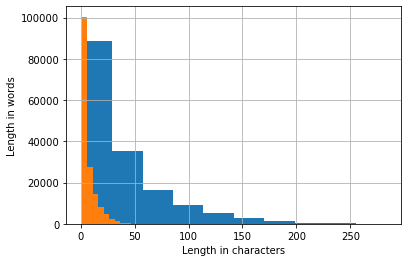

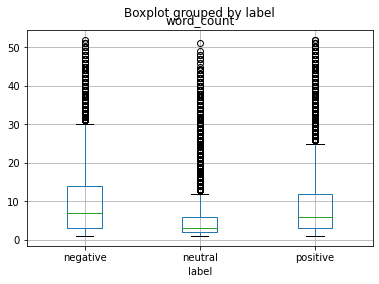

In [10]:
data_analysis(train_df, 'sentence')

**Detokenize**

In [31]:
detokenizerTB = TreebankWordDetokenizer()

In [ ]:
def detokenize(s):
    return detokenizer.detokenize(s.split())

In [ ]:
train_df = train_df.apply()

 ### Feature Experiments:
 1. Use Unigram (simple) 
 
     1.1 Tweeter tokenization     
     1.2 TreebankWordTokenizer
     
 2. Use bigram 
 
 3. GolVe? 
 
 4. Bert representations (CSL)
 
 5. BERT avrg



In [36]:
tokenizerTB = TreebankWordTokenizer()
tokenizerTwtr = TweetTokenizer()

In [11]:
def unigrams_phi(text):
    return Counter(text.lower().split())

In [37]:
def unigrams_phi_tokenize(text):
    return Counter(tokenizerTwtr.tokenize(text))

In [ ]:
def bigrams_phi(text):
    toks = text.lower().split()
    left = [utils.START_SYMBOL] + toks
    right = toks + [utils.END_SYMBOL]
    grams = list(zip(left, right))
    return Counter(grams)

In [27]:
train_dataset = sst.build_dataset(
    train_df,
    phi=unigrams_phi,
    vectorizer=None)

### Model Experiments:

1. logistic regression
2. Torch softmax
3. NN classifier 
4. RNN ? LSTM? 

In [12]:
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier

def fit_softmax_classifier(X, y):
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='auto')
    mod.fit(X, y)
    return mod

class TorchSoftmaxClassifier(TorchShallowNeuralClassifier):

    def build_graph(self):
        return nn.Linear(self.input_dim, self.n_classes_)

def fit_torch_softmax(X, y):
    mod = TorchSoftmaxClassifier(l2_strength=0.0001)
    mod.fit(X, y)
    return mod

def fit_nn_classifier(X, y):
    mod = TorchShallowNeuralClassifier(
        hidden_dim=100,
        early_stopping=True,      # A basic early stopping set-up.
        validation_fraction=0.1,  # If no improvement on the
        tol=1e-5,                 # validation set is seen within
        n_iter_no_change=10)      # `n_iter_no_change`, we stop.
    mod.fit(X, y)
    return mod



### Experiments 

#### fit_softmax_classifier
`_ = sst.experiment(
    train_df,
    unigrams_phi,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    train_size=0.7,
    score_func=utils.safe_macro_f1,
    verbose=True)`
    
macro avg      0.508     0.518     **0.499**

`_ = sst.experiment(
    train_df_nosub, # with NO subtrees
    unigrams_phi_tokenize,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    train_size=0.7,
    score_func=utils.safe_macro_f1,
    verbose=True)`
    
macro avg      0.530     0.529     **0.515**

`_ = sst.experiment(
    train_df, # with subtrees
    unigrams_phi,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    train_size=0.7,
    score_func=utils.safe_macro_f1,
    verbose=True)`
    
macro avg      0.588     0.586     **0.586**          

`_ = sst.experiment(
    train_df, # with subtrees
    unigrams_phi_tokenize,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    train_size=0.7,
    score_func=utils.safe_macro_f1,
    verbose=True)`.
    
macro avg      0.595     0.593     **0.593**


In [39]:
_ = sst.experiment(
    train_df_nosub, # with NO subtrees
    unigrams_phi_tokenize,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    train_size=0.7,
    score_func=utils.safe_macro_f1,
    verbose=True)

              precision    recall  f1-score   support

    negative      0.626     0.696     0.659       428
     neutral      0.333     0.144     0.201       229
    positive      0.631     0.748     0.685       444

    accuracy                          0.602      1101
   macro avg      0.530     0.529     0.515      1101
weighted avg      0.567     0.602     0.574      1101



In [13]:
_ = sst.experiment(
    train_df, # with subtrees
    unigrams_phi,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    train_size=0.7,
    score_func=utils.safe_macro_f1,
    verbose=True)

              precision    recall  f1-score   support

    negative      0.712     0.654     0.682       428
     neutral      0.360     0.336     0.348       229
    positive      0.690     0.768     0.727       444

    accuracy                          0.634      1101
   macro avg      0.588     0.586     0.586      1101
weighted avg      0.630     0.634     0.631      1101



In [38]:
_ = sst.experiment(
    train_df, # with subtrees
    unigrams_phi_tokenize,
    fit_softmax_classifier,
    assess_dataframes=sst.dev_reader(SST_HOME),
    train_size=0.7,
    score_func=utils.safe_macro_f1,
    verbose=True)

              precision    recall  f1-score   support

    negative      0.714     0.675     0.694       428
     neutral      0.375     0.328     0.350       229
    positive      0.696     0.777     0.734       444

    accuracy                          0.644      1101
   macro avg      0.595     0.593     0.593      1101
weighted avg      0.636     0.644     0.638      1101



----------------------------------------------------------------------

In [ ]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# NOTE: MODULES, CODE AND DATASETS REQUIRED FOR YOUR ORIGINAL SYSTEM
# SHOULD BE ADDED BELOW THE 'IS_GRADESCOPE_ENV' CHECK CONDITION. DOING
# SO ABOVE THE CHECK MAY CAUSE THE AUTOGRADER TO FAIL.

# START COMMENT: Enter your system description in this cell.
# My peak score was: MY_NUMBER
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass

# STOP COMMENT: Please do not remove this comment.

## Bakeoff [1 point]

As we said above, the bakeoff evaluation data is the official SST test-set release and a new test set derived from the same sources and labeling methods as for `bakeoff_dev`.

For this bakeoff, you'll evaluate your original system from the above homework problem on these test sets. Our metric will be the mean of the macro-F1 values, which weights both datasets equally despite their differing sizes.

The central requirement for your system is that you have define a `predict_one` method for it that maps a text (str) directly to a label prediction – one of 'positive', 'negative', 'neutral'. If you used `sst.experiment` with `vectorize=True`, then the following function (for `softmax_experiment`) will be easy to adapt – you probably just need to change the variable `softmax_experiment` to the variable for your experiment output.

In [ ]:
def predict_one_softmax(text):
    # Singleton list of feature dicts:
    feats = [softmax_experiment['phi'](text)]
    # Vectorize to get a feature matrix:
    X = softmax_experiment['train_dataset']['vectorizer'].transform(feats)
    # Standard sklearn `predict` step:
    preds = softmax_experiment['model'].predict(X)
    # Be sure to return the only member of the predictions,
    # rather than the singleton list:
    return preds[0]

If you used an RNN like the one we demoed above, then featurization is a bit more straightforward:

In [ ]:
def predict_one_rnn(text):
    # List of tokenized examples:
    X = [rnn_experiment['phi'](text)]
    # Standard `predict` step on a list of lists of str:
    preds = rnn_experiment['model'].predict(X)
    # Be sure to return the only member of the predictions,
    # rather than the singleton list:
    return preds[0]

The following function is used to create the bakeoff submission file. Its arguments are your `predict_one` function and an output filename (str).

In [ ]:
def create_bakeoff_submission(
        predict_one_func,
        output_filename='cs224u-sentiment-bakeoff-entry.csv'):

    bakeoff_test = sst.bakeoff_test_reader(SST_HOME)
    sst_test = sst.test_reader(SST_HOME)
    bakeoff_test['dataset'] = 'bakeoff'
    sst_test['dataset'] = 'sst3'
    df = pd.concat((bakeoff_test, sst_test))

    df['prediction'] = df['sentence'].apply(predict_one_func)

    df.to_csv(output_filename, index=None)

Thus, for example, the following will create a bake-off entry based on `predict_one_softmax`:

In [ ]:
# This check ensure that the following code only runs on the local environment only.
# The following call will not be run on the autograder environment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    create_bakeoff_submission(predict_one_softmax)

This creates a file `cs224u-sentiment-bakeoff-entry.csv` in the current directory. That file should be uploaded as-is. Please do not change its name.

Only one upload per team is permitted, and you should do no tuning of your system based on what you see in our bakeoff prediction file – you should not study that file in anyway, beyond perhaps checking that it contains what you expected it to contain. The upload function will do some additional checking to ensure that your file is well-formed.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points.

## Submission Instruction

Review and follow the [Homework and bake-off code: Formatting guide](hw_formatting_guide.ipynb).
Please do not change the file name as described below.

Submit the following files to Gradescope:

- `hw_sentiment.ipynb` (this notebook)
- `cs224u-sentiment-bakeoff-entry.csv` (bake-off output)
